[*********************100%***********************]  8 of 8 completed
<ipython-input-9-ac83502deac6>:54: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fx_returns_rub = fx_data_rub.pct_change().dropna()



--- Adjusted Weights 2016-2016 ---
ARS/RUB    0.164010
BRL/RUB   -0.074354
CHF/RUB    0.020195
JPY/RUB   -0.435394
MXN/RUB    0.010256
TRY/RUB    0.113642
ZAR/RUB    0.182149
dtype: float64

--- Adjusted Weights 2016-2016 ---
ARS/RUB    0.216684
BRL/RUB   -0.056087
CHF/RUB   -0.079374
JPY/RUB   -0.144780
MXN/RUB    0.178552
TRY/RUB   -0.165883
ZAR/RUB   -0.158640
dtype: float64

--- Adjusted Weights 2016-2016 ---
ARS/RUB    0.248140
BRL/RUB   -0.088775
CHF/RUB   -0.002504
JPY/RUB   -0.129008
MXN/RUB    0.197659
TRY/RUB   -0.316785
ZAR/RUB    0.017129
dtype: float64

--- Adjusted Weights 2016-2017 ---
ARS/RUB    0.251240
BRL/RUB   -0.111974
CHF/RUB   -0.000941
JPY/RUB   -0.076824
MXN/RUB    0.106957
TRY/RUB   -0.346156
ZAR/RUB    0.105907
dtype: float64

--- Adjusted Weights 2017-2017 ---
ARS/RUB    0.206181
BRL/RUB   -0.118903
CHF/RUB    0.065810
JPY/RUB   -0.077323
MXN/RUB    0.079137
TRY/RUB   -0.338240
ZAR/RUB    0.114405
dtype: float64

--- Adjusted Weights 2017-2017 ---
ARS/RUB  

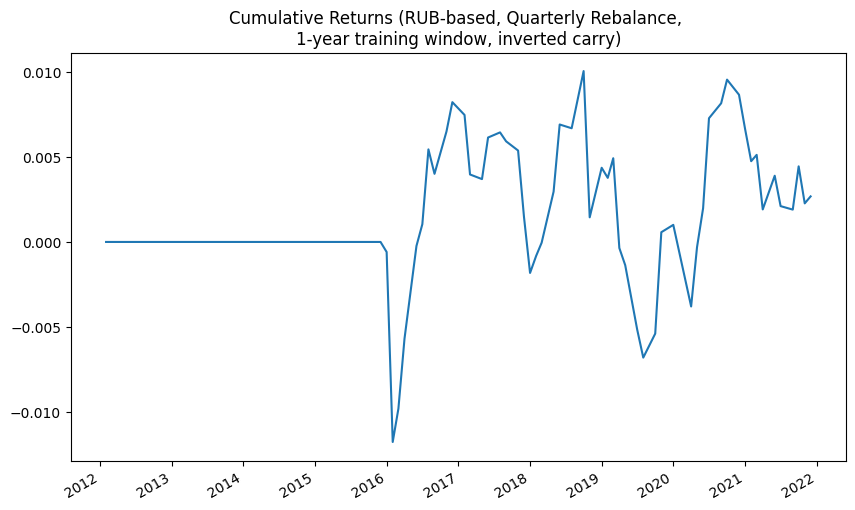


============== RESULTS ==============
Annualized Return:      1.4095%
Annualized Volatility:  5.2437%
Sharpe Ratio:           0.2688
Skewness:               -0.8986


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from numpy.linalg import inv
from datetime import datetime

start_date = "2012-01-01"
end_date   = "2021-12-31"

# quarterly rebalancing (January 1, April 1, July 1, October 1)
rebalance_dates = [
    "2016-01-01", "2016-04-01", "2016-07-01", "2016-10-01",
    "2017-01-01", "2017-04-01", "2017-07-01", "2017-10-01",
    "2018-01-01", "2018-04-01", "2018-07-01", "2018-10-01",
    "2019-01-01", "2019-04-01", "2019-07-01", "2019-10-01",
    "2020-01-01", "2020-04-01", "2020-07-01", "2020-10-01",
    "2021-01-01"
]

# Training window = 1 year
window_in_years = 1

transaction_cost_rate = 0.0

# 1) Data

currencies = {
    "JPY/USD": "JPY=X",
    "CHF/USD": "CHF=X",
    "RUB/USD": "RUB=X",
    "ARS/USD": "ARS=X",
    "TRY/USD": "TRY=X",
    "MXN/USD": "MXN=X",
    "BRL/USD": "BRL=X",
    "ZAR/USD": "ZAR=X"
}

fx_data = yf.download(list(currencies.values()), start=start_date, end=end_date)
fx_data = fx_data.xs('Close', level=0, axis=1)
fx_data = fx_data.rename(columns=lambda s: s.replace("=X", "/USD"))

# Recalculation of ER into RUB (c/RUB = (c/USD)/(RUB/USD))
fx_data_rub = pd.DataFrame(index=fx_data.index)
for col in fx_data.columns:
    if col != "RUB/USD":
        ccy_name = col.replace("/USD", "/RUB")
        fx_data_rub[ccy_name] = fx_data[col] / fx_data["RUB/USD"]

# Quarterly returns
fx_returns_rub = fx_data_rub.pct_change().dropna()

# Nominal interest rates uploading
interest_data = pd.read_csv("all_interest_rates_2012_2021.csv",
                                parse_dates=["DATE"],
                                index_col="DATE")

common_index = fx_returns_rub.index.intersection(interest_data.index)
interest_data = interest_data.loc[common_index]
fx_returns_rub = fx_returns_rub.loc[common_index]
cols_foreign = [c for c in interest_data.columns if c != "RUB"]
forward_premiums_df = interest_data[cols_foreign].subtract(interest_data["RUB"], axis=0)

# "JPY" -> "JPY/RUB" etc.
forward_premiums_df.columns = [c + "/RUB" for c in forward_premiums_df.columns]

# 2) Weights calculations

def compute_cscar_weights(returns: pd.DataFrame, f_premiums: pd.Series) -> pd.Series:
    cov_matrix = returns.cov()
    f_array = f_premiums.reindex(cov_matrix.columns).values
    w_raw = inv(cov_matrix.values) @ f_array
    return pd.Series(w_raw, index=cov_matrix.columns)

def transaction_cost(old_w, new_w, cost_rate=0.0):
    if old_w is None:
        return 0.0
    delta = new_w - old_w
    return cost_rate * delta.abs().sum()


# 3) Rebalancing

dates_sorted = fx_returns_rub.index.sort_values()
portfolio_value_ts = pd.Series(index=dates_sorted, dtype=float)
portfolio_value_ts.iloc[0] = 1.0
portfolio_returns_series = pd.Series(index=dates_sorted, dtype=float)

current_weights = None
weights_history = {}

for i, reb_date_str in enumerate(rebalance_dates):
    reb_date = pd.Timestamp(reb_date_str)

    # Window = 1 year
    train_start = reb_date - pd.DateOffset(years=window_in_years)
    train_end   = reb_date

    # Train-period data
    mask_train = (fx_returns_rub.index >= train_start) & (fx_returns_rub.index < train_end)
    returns_train = fx_returns_rub.loc[mask_train]

    mask_fprem = (forward_premiums_df.index >= train_start) & (forward_premiums_df.index < train_end)
    f_prem = forward_premiums_df.loc[mask_fprem].mean()

    w_cscar = compute_cscar_weights(returns_train, f_prem)

    # Normalization
    sum_abs = w_cscar.abs().sum()
    if sum_abs != 0:
        w_cscar /= sum_abs

    cost = transaction_cost(current_weights, w_cscar, cost_rate=transaction_cost_rate)
    current_weights = w_cscar
    weights_history[reb_date] = w_cscar.copy()

    if i < len(rebalance_dates) - 1:
        next_reb_date = pd.Timestamp(rebalance_dates[i+1])
    else:
        next_reb_date = pd.Timestamp(end_date)

    # Apply weights
    mask_test = (fx_returns_rub.index >= reb_date) & (fx_returns_rub.index < next_reb_date)
    test_dates = fx_returns_rub.loc[mask_test].index

    for dt in test_dates:
        old_value = portfolio_value_ts.loc[dt]
        if pd.isna(old_value):
            old_value = portfolio_value_ts.ffill().dropna().iloc[-1]

        r_vec = fx_returns_rub.loc[dt, current_weights.index]
        port_r = (r_vec * current_weights).sum()

        if dt == test_dates[0]:
            new_value = old_value * (1 - cost) * (1 + port_r)
        else:
            new_value = old_value * (1 + port_r)

        portfolio_value_ts.loc[dt] = new_value
        portfolio_returns_series.loc[dt] = (new_value - old_value) / old_value

portfolio_value_ts.ffill(inplace=True)


# 4) Output (weights)

sorted_reb_dates = sorted(weights_history.keys())
for i in range(len(sorted_reb_dates)):
    d0 = sorted_reb_dates[i]
    if i < len(sorted_reb_dates) - 1:
        d1 = sorted_reb_dates[i+1]
    else:
        d1 = pd.Timestamp("2022-01-01")
    print(f"\n--- Adjusted Weights {d0.year}-{d1.year} ---")
    print(weights_history[d0])

# 5) Graphs

plt.figure(figsize=(10,6))
((portfolio_value_ts / portfolio_value_ts.iloc[0]) - 1).plot()
plt.title("Cumulative Returns (RUB-based, Quarterly Rebalance, \n1-year training window, inverted carry)")
plt.show()

# 6. Metrics

daily_returns = portfolio_returns_series.dropna()
ann_vol = daily_returns.std() * np.sqrt(252)
annual_ret = daily_returns.mean() * 252
sharpe_ratio = annual_ret / ann_vol

from scipy.stats import skew
port_skew = skew(daily_returns)

print("\n============== RESULTS ==============")
print(f"Annualized Return:      {annual_ret:.4%}")
print(f"Annualized Volatility:  {ann_vol:.4%}")
print(f"Sharpe Ratio:           {sharpe_ratio:.4f}")
print(f"Skewness:               {port_skew:.4f}")


<Figure size 1200x600 with 0 Axes>

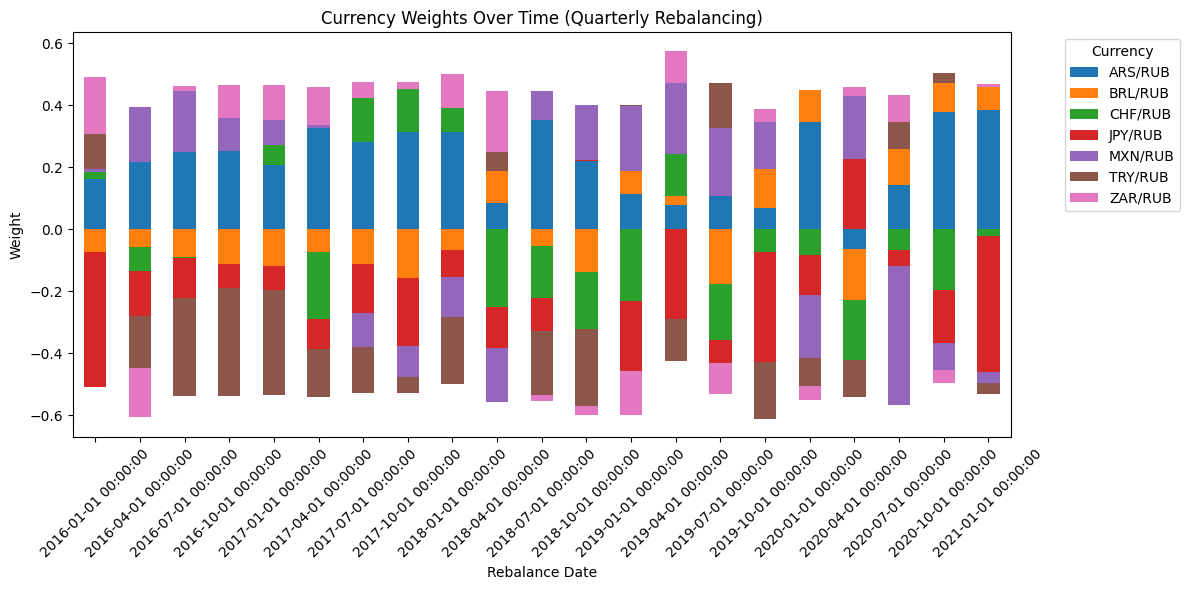


   FINAL METRICS
Annualized Volatility (std): 5.2437%
Annualized Sharpe Ratio:      0.2688
Annualized CAGR:      0.0003
Skewness:                    -0.8986
Max Drawdown:                -1.6708%
Calmar Ratio:                0.1606


In [ ]:
weights_df = pd.DataFrame(weights_history).T

# Visualization of portfolio weights by year
plt.figure(figsize=(12, 6))
weights_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Currency Weights Over Time (Quarterly Rebalancing)")
plt.xlabel("Rebalance Date")
plt.ylabel("Weight")
plt.legend(title="Currency", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Continue to calculate metrics
daily_returns = portfolio_returns_series.dropna()
ann_vol = daily_returns.std() * np.sqrt(252)
sharpe_ratio = (daily_returns.mean() * 252) / ann_vol
port_skew = skew(daily_returns.dropna())

rolling_max = portfolio_value_ts.cummax()
drawdown = (portfolio_value_ts / rolling_max) - 1
max_drawdown = drawdown.min()

calmar_ratio = (portfolio_value_ts.iloc[-1] / portfolio_value_ts.iloc[0] - 1) / abs(max_drawdown) if max_drawdown != 0 else np.nan

# CAGR
total_years = (portfolio_value_ts.index[-1] - portfolio_value_ts.index[0]).days / 365.25
cagr_corrected = (portfolio_value_ts.iloc[-1] / portfolio_value_ts.iloc[0]) ** (1 / total_years) - 1


print("\n=======================")
print("   FINAL METRICS")
print("=======================")
print(f"Annualized Volatility (std): {ann_vol:.4%}")
print(f"Annualized Sharpe Ratio:      {sharpe_ratio:.4f}")
print(f"Annualized CAGR:      {cagr_corrected:.4f}")
print(f"Skewness:                    {port_skew:.4f}")
print(f"Max Drawdown:                {max_drawdown:.4%}")
print(f"Calmar Ratio:                {calmar_ratio:.4f}")

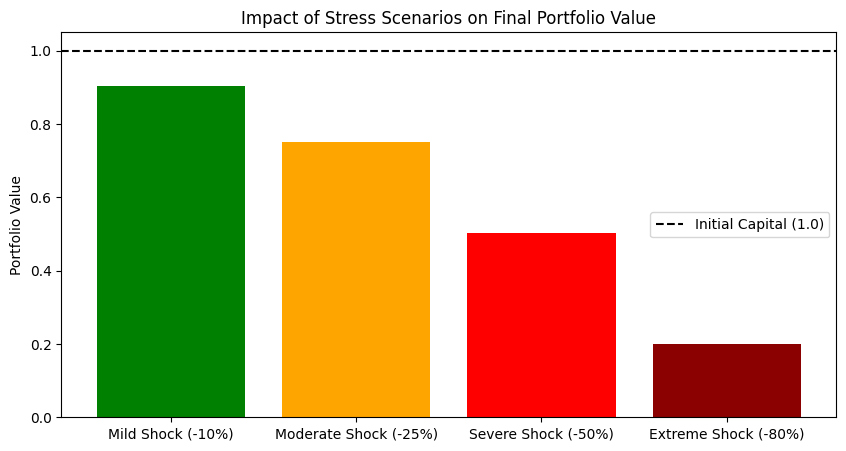

                       Final Portfolio Value
Mild Shock (-10%)                   0.902415
Moderate Shock (-25%)               0.752013
Severe Shock (-50%)                 0.501342
Extreme Shock (-80%)                0.200537


In [ ]:
# Scenario (risk) analysis of the Carry-Trade strategy

import matplotlib.pyplot as plt

# Defining stress scenarios
stress_scenarios = {
    "Mild Shock (-10%)": 0.90,  # A small crisis (the ruble is depreciating, profitability is falling by 10%)
    "Moderate Shock (-25%)": 0.75,  # An average crisis (for example, 2014 or 2020)
    "Severe Shock (-50%)": 0.50,  # Global crisis (default, sanctions, etc.)
    "Extreme Shock (-80%)": 0.20  # Catastrophic scenario (for example, devaluation in 1998)
}

# Calculating the impact of scenarios on cumulative returns
initial_value = portfolio_value_ts.iloc[0]
final_value = portfolio_value_ts.iloc[-1]

scenario_results = {scenario: final_value * impact for scenario, impact in stress_scenarios.items()}

# Vizualization
plt.figure(figsize=(10, 5))
plt.bar(scenario_results.keys(), scenario_results.values(), color=['green', 'orange', 'red', 'darkred'])
plt.axhline(y=initial_value, color='black', linestyle="--", label="Initial Capital (1.0)")
plt.title("Impact of Stress Scenarios on Final Portfolio Value")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


scenario_df = pd.DataFrame.from_dict(scenario_results, orient='index', columns=["Final Portfolio Value"])
print(scenario_df)
